# Boosted decision tree tutorial

***
## Introduction:
#### Boosted decision tree code:
We'll use the python API for the [XGBoost (eXtreme Gradient Boosting) library](https://github.com/dmlc/xgboost).

#### Data:
[Atlas](https://home.cern/about/experiments/atlas) hosted a [Kaggle](https://www.kaggle.com/) competition for identifying Higgs to tau tau events, [the Higgs Boson Machine Learning Challenge](https://www.kaggle.com/c/higgs-boson/data). The training data for this event contains 250,000 labeled, simulated Atlas events in csv format described [here](https://www.kaggle.com/c/higgs-boson/data) and [here](https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf). You can download it youself, or we have a small subset (10k events) in the "data" directory in this repository that we use here.

#### Data handling:
If you don't have [pandas](http://pandas.pydata.org/), you should get pandas. It's an amazing tool for exploring data in Python.
***
#### Install XGBoost:
Assuming you have python, numpy, matplotlib, and pandas installed, you just need to install XGBoost. Detailed installation instructions are [here](https://xgboost.readthedocs.io/en/latest/build.html). Or, just do this (in your terminal):
```bash
git clone --recursive https://github.com/dmlc/xgboost
cd xgboost
make
```
***
#### Links:
A lot of this was borrowed from other sources. These sources and other good places for information about XGBoost and BDTs in general are here:

XGBoost demo: [Example of how to use XGBoost Python Module to run Kaggle Higgs competition](https://github.com/dmlc/xgboost/tree/master/demo/kaggle-higgs)

Blog post by phunther: [Winning solution of Kaggle Higgs competition: what a single model can do?](https://no2147483647.wordpress.com/2014/09/17/winning-solution-of-kaggle-higgs-competition-what-a-single-model-can-do/)

XGBoost Kaggle Higgs solution: https://github.com/hetong007/higgsml

***

## Tutorial:

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

%matplotlib inline

### The data
#### Load data:
First, load in the data and look at it. We've taken a 10k event subsample of the Kaggle training data. Then we'll put it in the right format for xgboost.

In [3]:
data = pd.read_csv('data/training_10k.csv')

Let's see what the data looks like:

In [134]:
print 'Size of data: {}'.format(data.shape)
print 'Number of events: {}'.format(data.shape[0])
print 'Number of columns: {}'.format(data.shape[1])

print '\nList of features in dataset:'
for col in data.columns:
    print col

Size of data: (10000, 33)
Number of events: 10000
Number of columns: 33

List of features in dataset:
EventId
DER_mass_MMC
DER_mass_transverse_met_lep
DER_mass_vis
DER_pt_h
DER_deltaeta_jet_jet
DER_mass_jet_jet
DER_prodeta_jet_jet
DER_deltar_tau_lep
DER_pt_tot
DER_sum_pt
DER_pt_ratio_lep_tau
DER_met_phi_centrality
DER_lep_eta_centrality
PRI_tau_pt
PRI_tau_eta
PRI_tau_phi
PRI_lep_pt
PRI_lep_eta
PRI_lep_phi
PRI_met
PRI_met_phi
PRI_met_sumet
PRI_jet_num
PRI_jet_leading_pt
PRI_jet_leading_eta
PRI_jet_leading_phi
PRI_jet_subleading_pt
PRI_jet_subleading_eta
PRI_jet_subleading_phi
PRI_jet_all_pt
Weight
Label


The data set has 10,000 events with 33 columns each. It looks like the first column is an identifier, and shouldn't be used as a feature. The last two columns "Weight" and "Label", are the weights and labels from the simulation, and also shouldn't be used as features (this information is all contained in the documentation).

Now we can look at how many events are signal and background:

In [149]:
# look at column labels --- notice last one is "Label" and first is "EventId" also "Weight"
print 'Number of signal events: {}'.format(len(data[data.Label == 's']))
print 'Number of background events: {}'.format(len(data[data.Label == 'b']))
print 'Fraction signal: {}'.format(len(data[data.Label == 's'])/(float)(len(data[data.Label == 's']) + len(data[data.Label == 'b'])))

Number of signal events: 3372
Number of background events: 6628
Fraction signal: 0.3372


#### Format data:
Now we should get the data into an XGBoost-friendly format. We can create DMatrix objects that will be used to train the BDT model. For now, we'll use all 30 of the features for training.

First, we'll sliceup the data into training and testing sets. Here, we take 20% for the test set, which is arbitrary.

In this file, all samples are independent and ordered randomly, so we can just grab a chunk. Check out [scikit-learn Cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) for dividing up samples in a responsible way.

We can also change the data type of the "Label" column to the pandas type "category" for easier use later.

In [141]:
data['Label'] = data.Label.astype('category')

In [142]:
data_train = data[:8000]
data_test = data[8000:]

Check to make sure we did it right:

In [150]:
print 'Number of training samples: {}'.format(len(data_train))
print 'Number of testing samples: {}'.format(len(data_test))

print '\nNumber of signal events in training set: {}'.format(len(data_train[data_train.Label == 's']))
print 'Number of background events in training set: {}'.format(len(data_train[data_train.Label == 'b']))
print 'Fraction signal: {}'.format(len(data_train[data_train.Label == 's'])/(float)(len(data_train[data_train.Label == 's']) + len(data_train[data_train.Label == 'b'])))

Number of training samples: 8000
Number of testing samples: 2000

Number of signal events in training set: 2688
Number of background events in training set: 5312
Fraction signal: 0.336


The DMatrix object takes as arguments:
- data --- the features
- label --- 1/0 or true/false (we have to convert our label to bool from string s/b)
- missing --- how missing values are represented (here as -999.0)
- feature_names --- the names of all of the features (optional)

In [151]:
feature_names = data.columns[1:-2]  # we skip the first and last two columns because they are the ID, weight, and label
train = xgb.DMatrix(data=data_train[feature_names],label=data_train.Label.cat.codes,missing=-999.0,feature_names=feature_names)
test = xgb.DMatrix(data=data_test[feature_names],label=data_test.Label.cat.codes,missing=-999.0,feature_names=feature_names)

Check if we did it right:

In [159]:
print 'Number of training samples: {}'.format(train.num_row())
print 'Number of testing samples: {}'.format(test.num_row())

print '\nNumber of signal events in training set: {}'.format(len(np.where(train.get_label())[0]))

Number of training samples: 8000
Number of testing samples: 2000

Number of signal events in training set: 2688


## Making the model
### Set hyperparameters
https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Make dictionary:

In [77]:
param = {}
# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 10  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
#param['eval_metric'] = 'error'          # evaluation metric for cross validation

num_trees = 100  # number of trees to make

## Now train!

In [78]:
booster = xgb.train(param,train,num_boost_round=num_trees)

In [79]:
preds = booster.predict(test)

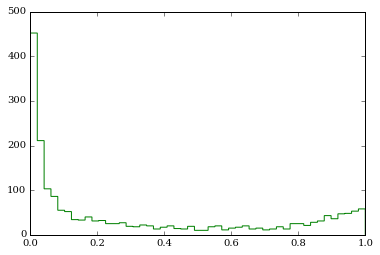

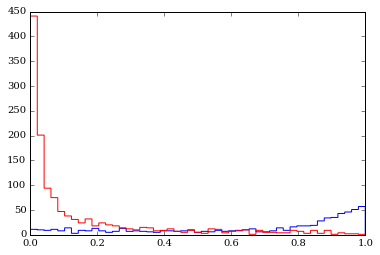

In [120]:
plt.figure();
plt.hist(preds,bins=np.linspace(0,1,50),histtype='step',color='green');

plt.figure();
plt.hist(preds[test.get_label().astype(bool)],bins=np.linspace(0,1,50),histtype='step',color='blue');
plt.hist(preds[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),histtype='step',color='red');

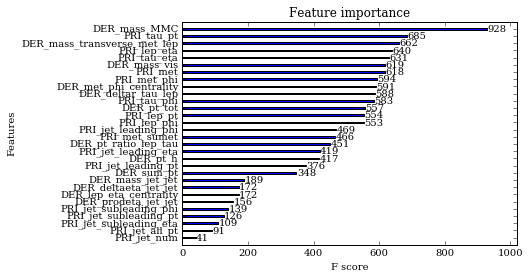

In [109]:
xgb.plot_importance(booster,grid=False);

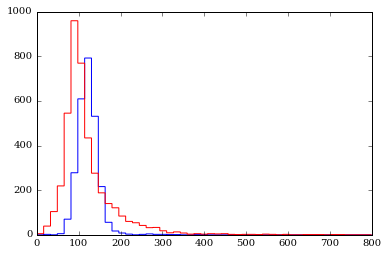

In [113]:
plt.figure();
plt.hist(data_train.DER_mass_MMC[data_train.Label == 's'],bins=np.linspace(0,800,50),histtype='step',color='blue');
plt.hist(data_train.DER_mass_MMC[data_train.Label == 'b'],bins=np.linspace(0,800,50),histtype='step',color='red');